# Find and save popular movies

In [2]:
import pandas as pd

class PopularMoviesRecommendationSystem:
    def __init__(self):
        self.movies_df = pd.read_csv("movielens_dataset/movies.csv")
        self.ratings_df = pd.read_csv("movielens_dataset/ratings.csv")
        
        self.sorted_movies_df = self.compute_and_sort_popularity()
        
        self.top_25_percent_movies = self.get_top_25_percent()

    def compute_and_sort_popularity(self):
        movie_ratings = pd.merge(self.ratings_df, self.movies_df, on='movieId')
        
        popularity = movie_ratings.groupby('movieId').agg(
            average_rating=pd.NamedAgg(column='rating', aggfunc='mean'),
            rating_count=pd.NamedAgg(column='rating', aggfunc='size')
        ).reset_index()
        
        movies_popularity = pd.merge(self.movies_df, popularity, on='movieId', how='left')
        
        return movies_popularity.sort_values(by=['rating_count', 'average_rating'], ascending=False)

    def get_top_25_percent(self):
        top_25_index = int(len(self.sorted_movies_df) * 0.25)
        return self.sorted_movies_df.head(top_25_index)

p = PopularMoviesRecommendationSystem()
popular_movies = p.top_25_percent_movies

# Results

## User Engagement and Satisfaction

In [8]:
# Retrieve info from the MovieLens Dataset
ratings_df = pd.read_csv("movielens_dataset/ratings.csv")
movies_df = pd.read_csv("movielens_dataset/movies.csv")
tags_df = pd.read_csv("movielens_dataset/tags.csv")

# Retrieve the results of simulation into dataframe
score_tag_results_df = pd.read_csv('simulation_results_score_tag.csv', converters={'recommendations': eval})
tag_results_df = pd.read_csv('simulation_results_tag.csv', converters={'recommendations': eval})
popular_results_df = pd.read_csv('simulation_results_popular.csv', converters={'recommendations': eval})

mood_genre_mapping = {
    "Joy": ['Adventure', 'Children', 'Fantasy', 'Comedy', 'Romance', 'Documentary', 'Musical', 'Animation'],
    "Sadness": ['Drama', 'Thriller', 'Mystery', 'War', 'Action', 'Crime', 'Western', 'Film-Noir'],
    "Anger": ['Action', 'Crime', 'Western', 'Film-Noir'],
    "Fear": ['Horror', 'Sci-Fi'],
    "Disgust": ['Action', 'Crime', 'Western', 'Film-Noir']
}

# Calculate genre score or mood relevance for movie according to the mood
def calculate_genre_score(genres, mood):
    genre_list = genres.split('|')
    mood_genres = mood_genre_mapping.get(mood, [])
    score = sum(genre in mood_genres for genre in genre_list) / len(mood_genres) if mood_genres else 0
    return score

for mood, mood_genres in mood_genre_mapping.items():
    movies_df[mood + '_genre_score'] = movies_df['genres'].apply(lambda genres: calculate_genre_score(genres, mood))

# Calculate the rate of positive feedback.
def positive_feedback_rate(feedbacks):
    positive_feedback = feedbacks.count('Like') + feedbacks.count('Perfect')
    return positive_feedback / len(feedbacks) if feedbacks else 0

# Calculate the range of recommendations to reach a 'Perfect' rating.
def range_of_recs_to_perfection(df):
    df = df[df['feedbacks'].apply(lambda x: 'Perfect' in x)]
    return df['number of recs'].min(), df['number of recs'].max()

# Calculate the number of popular movies in a set of recommendations
def count_popular(recommendations, popular_movies_set):
    return sum(movie in popular_movies_set for movie in recommendations)

# A function to count 'Like' and 'Dislike' feedback before 'Perfect'
def count_feedback_before_perfect(feedbacks_string):
    feedbacks_list = feedbacks_string.strip("[]").replace("'", "").split(',')
    feedbacks_list = [feedback.strip() for feedback in feedbacks_list]
    
    like_count, dislike_count = 0, 0

    for feedback in feedbacks_list:
        if feedback == 'Perfect':
            break
        elif feedback == 'Like':
            like_count += 1
        elif feedback == 'Dislike':
            dislike_count += 1

    return like_count, dislike_count
    
def analyze_recommendations(df, name):
    popular_movies_set = set(popular_movies['title'])
    """Analyze and print statistics for a given recommendation DataFrame."""
    df['positive_feedback_rate'] = df['feedbacks'].apply(positive_feedback_rate)
    overall_positive_feedback_rate = df['positive_feedback_rate'].mean()
    overall_recs_to_perfection = df['number of recs'].mean()
    rec_range = range_of_recs_to_perfection(df)

    df['popular_count'] = df['recommendations'].apply(lambda recs: count_popular(recs, popular_movies_set))
    df['non_popular_count'] = df['recommendations'].apply(lambda recs: len(recs) - count_popular(recs, popular_movies_set))
    
    overall_popular_count = df['popular_count'].sum()
    overall_non_popular_count = df['non_popular_count'].sum()

    print(f"{name} Overall Positive Feedback Rate: {overall_positive_feedback_rate}")
    print(f"{name} Overall Average Recommendations to Perfection: {overall_recs_to_perfection}")
    print(f"{name} Range to 'Perfect': {rec_range}")
    print(f"Overall popular movies recommended: {overall_popular_count}")
    print(f"Overall non-popular movies recommended: {overall_non_popular_count}")

    df['likes_before_perfect'], df['dislikes_before_perfect'] = zip(*df['feedbacks'].apply(count_feedback_before_perfect))
    
    average_likes_before_perfect = df['likes_before_perfect'].mean()
    average_dislikes_before_perfect = df['dislikes_before_perfect'].mean()
    
    print(f"Average Likes before Perfect: {average_likes_before_perfect}")
    print(f"Average Dislikes before Perfect: {average_dislikes_before_perfect}")
    print("\n")


# Apply the analysis function to each recommendation system
analyze_recommendations(score_tag_results_df, "Collaborative-Based")
analyze_recommendations(tag_results_df, "Content-Based")
analyze_recommendations(popular_results_df, "Popularity-Based")


Collaborative-Based Overall Positive Feedback Rate: 0.08442280564799978
Collaborative-Based Overall Average Recommendations to Perfection: 1.9918032786885247
Collaborative-Based Range to 'Perfect': (1, 4)
Overall popular movies recommended: 785
Overall non-popular movies recommended: 430
Average Likes before Perfect: 0.6475409836065574
Average Dislikes before Perfect: 0.3442622950819672


Content-Based Overall Positive Feedback Rate: 0.0774901873589696
Content-Based Overall Average Recommendations to Perfection: 5.483606557377049
Content-Based Range to 'Perfect': (1, 12)
Overall popular movies recommended: 439
Overall non-popular movies recommended: 2906
Average Likes before Perfect: 2.440983606557377
Average Dislikes before Perfect: 2.042622950819672


Popularity-Based Overall Positive Feedback Rate: 0.09030477913443444
Popularity-Based Overall Average Recommendations to Perfection: 3.2426229508196722
Popularity-Based Range to 'Perfect': (1, 17)
Overall popular movies recommended: 197

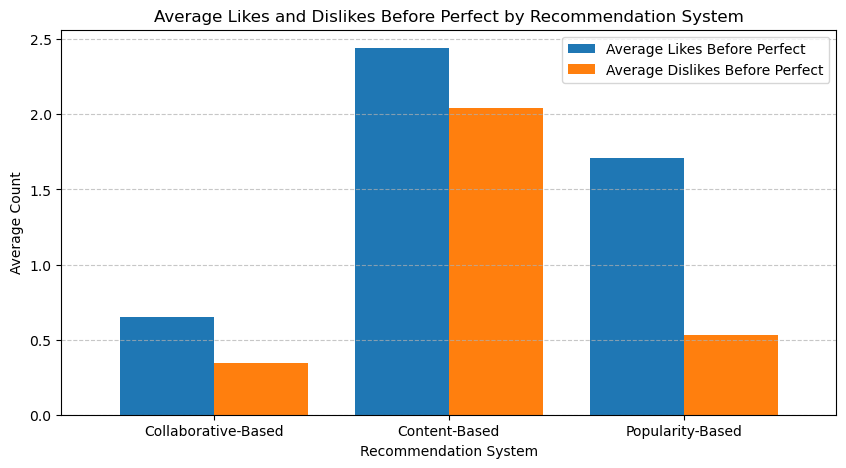

In [54]:
import matplotlib.pyplot as plt

data = {
    'System': ['Collaborative-Based', 'Content-Based', 'Popularity-Based'],
    'Average Likes Before Perfect': [0.6475409836065574, 2.440983606557377, 1.7098360655737705],
    'Average Dislikes Before Perfect': [0.3442622950819672, 2.042622950819672, 0.5327868852459017]
}
df = pd.DataFrame(data)

df.set_index('System', inplace=True)

ax = df.plot(kind='bar', figsize=(10, 5), width=0.8)
ax.set_title('Average Likes and Dislikes Before Perfect by Recommendation System')
ax.set_ylabel('Average Count')
ax.set_xlabel('Recommendation System')
plt.xticks(rotation=0) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


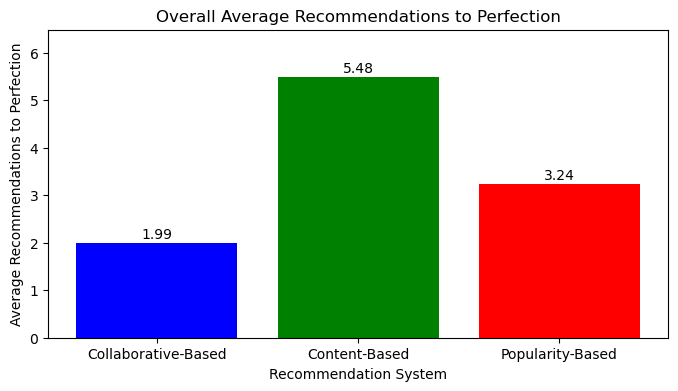

In [71]:
systems= ['Collaborative-Based', 'Content-Based', 'Popularity-Based']
averages = [1.9918032786885247, 5.483606557377049, 3.2426229508196722]

=plt.figure(figsize=(8, 4))
plt.bar(systems, averages, color=['blue', 'green', 'red'])
plt.title('Overall Average Recommendations to Perfection')
plt.xlabel('Recommendation System')
plt.ylabel('Average Recommendations to Perfection')
plt.ylim(0, max(averages) + 1) 

for i in range(len(averages)):
    plt.text(i, averages[i] + 0.1, f'{averages[i]:.2f}', ha = 'center', color = 'black')

plt.show()

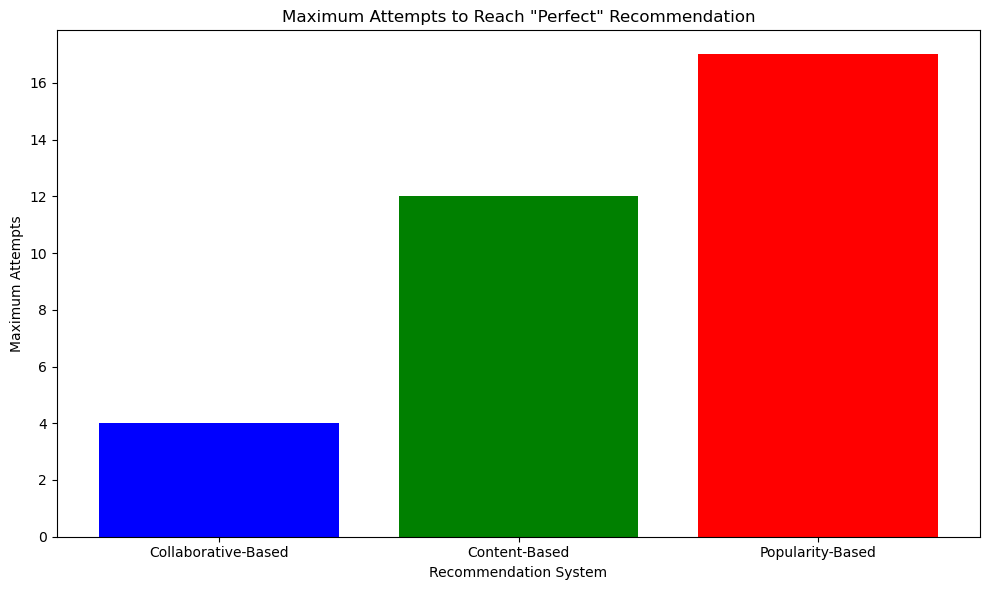

In [12]:
import matplotlib.pyplot as plt

strategies = ['Collaborative-Based', 'Content-Based', 'Popularity-Based']
max_attempts = [4, 12, 17]

plt.figure(figsize=(10, 6))
plt.bar(strategies, max_attempts, color=['blue', 'green', 'red'])

plt.title('Maximum Attempts to Reach "Perfect" Recommendation')
plt.xlabel('Recommendation System')
plt.ylabel('Maximum Attempts')

plt.tight_layout()
plt.show()


## Mood Integration Results 

In [15]:
import numpy as np

def calculate_genre_stats_with_counts(df, movies_df, mood_genre_mapping):
    
    # Function to calculate the genre score for a single movie
    def calculate_genre_score(movie, mood):
        movie_genres = movies_df.loc[movies_df['title'] == movie, 'genres'].values
        if movie_genres.size > 0:
            movie_genres = movie_genres[0].split('|')
            mood_genres = mood_genre_mapping[mood]
            score = sum(genre in mood_genres for genre in movie_genres) / len(mood_genres)
            return score
        else:
            return None

    # Function to apply genre score calculation for a row in the DataFrame
    def genre_scores_for_row(row):
        mood = row['mood']
        recommendations = row['recommendations'] if isinstance(row['recommendations'], list) else eval(row['recommendations'])
        genre_scores = [calculate_genre_score(movie, mood) for movie in recommendations]
        genre_scores = [score for score in genre_scores if score is not None]  # Remove None values
        return genre_scores

    df['genre_scores'] = df.apply(genre_scores_for_row, axis=1)

    # Count how many movies had a score of 0 and how many had more than 0
    df['count_zero_score'] = df['genre_scores'].apply(lambda scores: sum(score == 0 for score in scores if score is not None))
    df['count_above_zero_score'] = df['genre_scores'].apply(lambda scores: sum(score > 0 for score in scores if score is not None))
    
    # Create a summary of the counts and statistics
    summary = {
        'count_zero_score': df['count_zero_score'].sum(),
        'count_above_zero_score': df['count_above_zero_score'].sum()
    }
    return summary

score_tag_summary = calculate_genre_stats_with_counts(score_tag_results_df, movies_df, mood_genre_mapping)
tag_summary = calculate_genre_stats_with_counts(tag_results_df, movies_df, mood_genre_mapping)
popular_summary = calculate_genre_stats_with_counts(popular_results_df, movies_df, mood_genre_mapping)

print("Summary for Collaborative-based recommendation system:")
print(score_tag_summary)
print("\nSummary for Content-based recommendation system:")
print(tag_summary)
print("\nSummary for Popularity-based recommendation system:")
print(popular_summary)

Summary for Collaborative-based recommendation system:
{'count_zero_score': 0, 'count_above_zero_score': 1215}

Summary for Content-based recommendation system:
{'count_zero_score': 0, 'count_above_zero_score': 3345}

Summary for Popularity-based recommendation system:
{'count_zero_score': 1064, 'count_above_zero_score': 914}


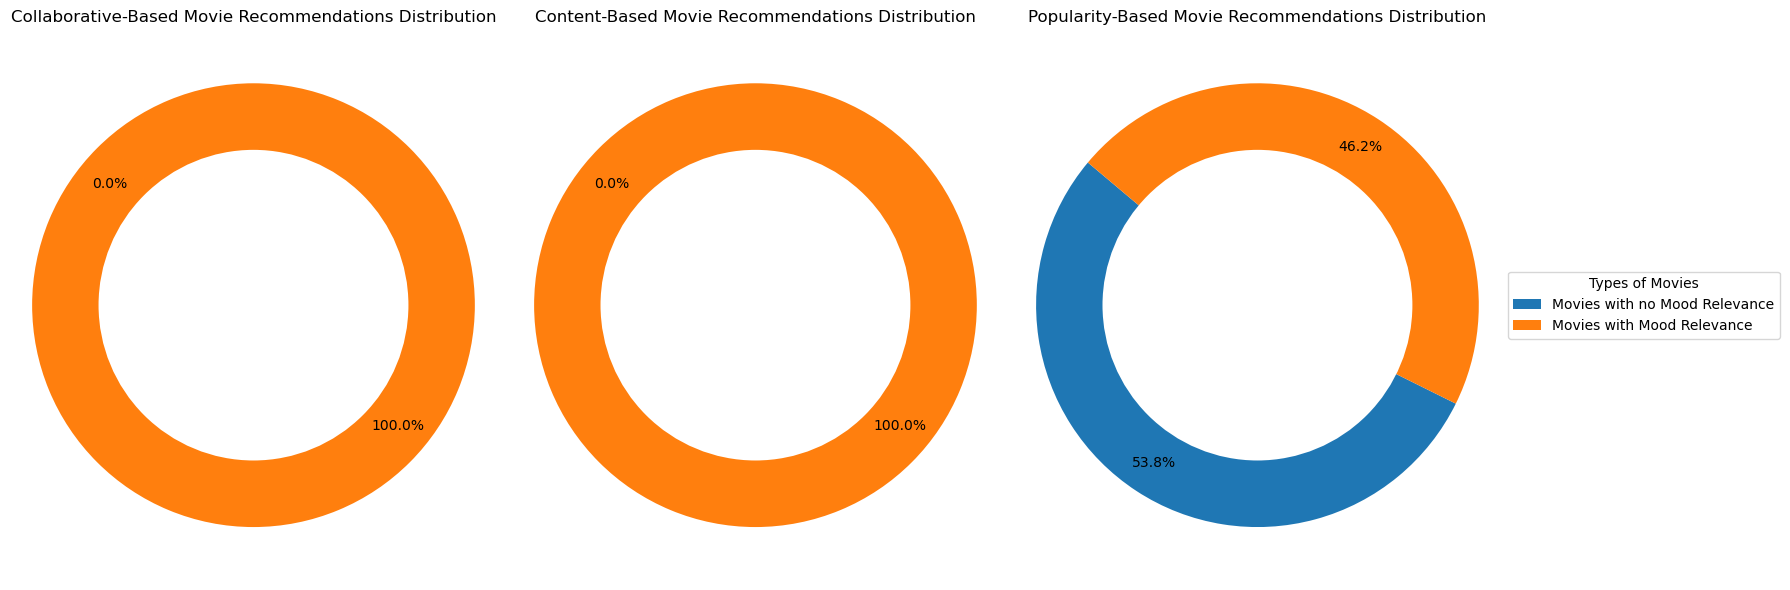

In [80]:
import matplotlib.pyplot as plt

data = {
    'Collaborative-Based': [0, 1215],
    'Content-Based': [0, 3345],
    'Popularity-Based': [1064, 914]
}

legend_labels = ['Movies with no Mood Relevance', 'Movies with Mood Relevance']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))  # Adjust figsize to fit your screen

for ax, (name, counts) in zip(axes, data.items()):
    wedges, texts, autotexts = ax.pie(counts, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
    
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    ax.add_artist(centre_circle)
    
    ax.set_title(f'{name} Movie Recommendations Distribution')
    ax.axis('equal')

plt.legend(wedges, legend_labels, title="Types of Movies", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout() 
plt.show()


## Diversity in Recommendations

In [61]:
def analyze_recommendations(df, name, popular_movies_set):
    unique_popular_counts = {}
    unique_non_popular_counts = {}

    for index, row in df.iterrows():
        user_id = row['userId']
        recommendations = row['recommendations']
        if user_id not in unique_popular_counts:
            unique_popular_counts[user_id] = set()
            unique_non_popular_counts[user_id] = set()

        # Count popular and non-popular movies
        for movie in recommendations:
            if movie in popular_movies_set and movie not in unique_popular_counts[user_id]:
                unique_popular_counts[user_id].add(movie)
            elif movie not in popular_movies_set and movie not in unique_non_popular_counts[user_id]:
                unique_non_popular_counts[user_id].add(movie)

    # Calculate the total counts of unique popular and non-popular recommendations
    total_unique_popular = sum(len(movies) for movies in unique_popular_counts.values())
    total_unique_non_popular = sum(len(movies) for movies in unique_non_popular_counts.values())

    print(f"{name} Total unique popular movies recommended: {total_unique_popular}")
    print(f"{name} Total unique non-popular movies recommended: {total_unique_non_popular}")

popular_movies_set = set(popular_movies['title'])
analyze_recommendations(score_tag_results_df, "Score-Tag", popular_movies_set)
analyze_recommendations(tag_results_df, "Tag-Based", popular_movies_set)
analyze_recommendations(popular_results_df, "Popularity-Based", popular_movies_set)


Score-Tag Total unique popular movies recommended: 785
Score-Tag Total unique non-popular movies recommended: 430
Tag-Based Total unique popular movies recommended: 439
Tag-Based Total unique non-popular movies recommended: 2906
Popularity-Based Total unique popular movies recommended: 1978
Popularity-Based Total unique non-popular movies recommended: 0


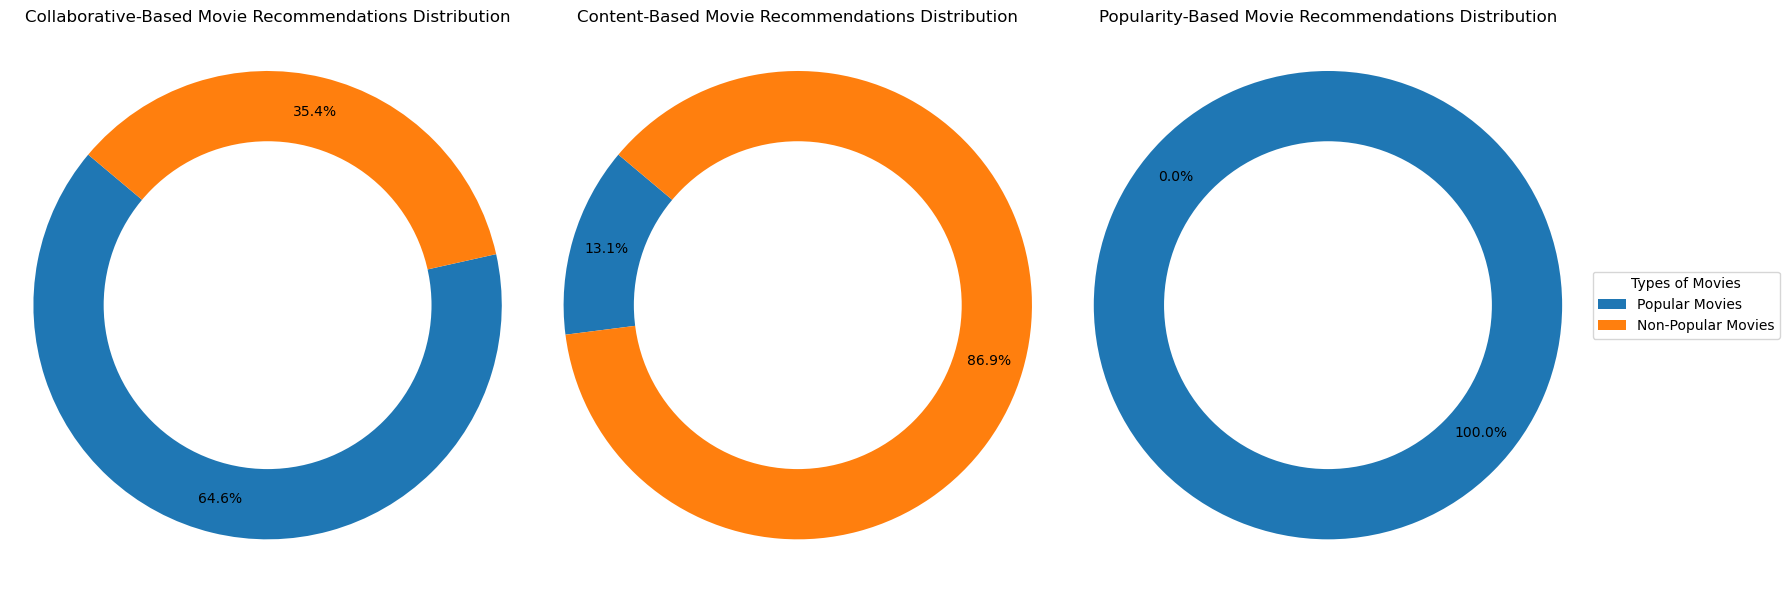

In [70]:
import matplotlib.pyplot as plt

data = {
    'Collaborative-Based': [785, 430],
    'Content-Based': [439, 2906],
    'Popularity-Based': [1978, 0]
}

legend_labels = ['Popular Movies', 'Non-Popular Movies']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6)) 

for ax, (name, counts) in zip(axes, data.items()):
    wedges, texts, autotexts = ax.pie(counts, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
    
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    ax.add_artist(centre_circle)
    
    ax.set_title(f'{name} Movie Recommendations Distribution')
    ax.axis('equal')  
    
plt.legend(wedges, legend_labels, title="Types of Movies", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()  
plt.show()
